## <center>Exploring Customer Segmentation and Customer Lifetime Value for Sales Forecasting</center>
---


In [1122]:
# Import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import topic modeling packages
# Top2Vec
from top2vec import Top2Vec

# Import customized Top2Vec utility functions
from top2vec_utils import compute_cv_coherence

# Gensim version
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.phrases import Phraser, Phrases
from gensim.models.ldamodel import LdaModel

# Import customized Gensim functions
from gensim_lda import (
    sent_to_words,
    remove_stopwords,
    make_bigrams,
    lemmatization,
    compute_coherence_values,
    format_topics_sentences,
)

# spacy for lemmatization
import spacy

# nltk
import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Time Series related packages
import calendar

# Import KModes for segmentation clustering
from kmodes.kmodes import KModes

# Import custom modules
from utils import plot_donut_chart

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1123]:
# Create np random seed
np.random.seed(42)

In [1124]:
# Read in data
retail_2009_2010 = pd.read_csv(
    r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\retail-customer-segmentation-forecasting\data\online_retail_2009_2010.csv"
)
retail_2010_2011 = pd.read_csv(
    r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\retail-customer-segmentation-forecasting\data\online_retail_2010_2011.csv"
)

## Data Preprocessing
---

In [1125]:
# Concatenate datasets to create a dataset ranging from 2009-2011
retail_data = pd.concat([retail_2009_2010, retail_2010_2011], axis=0)

### Variable Names and Data Types

In [1126]:
# Preview data
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom


Let's convert the variable names from camel case to snake case so we can conform with standard python naming conventions.

In [1127]:
# Convert all features from camel case to snake case
retail_data.rename(
    columns={
        "Invoice": "invoice",
        "StockCode": "stock_code",
        "Description": "description",
        "Quantity": "quantity",
        "InvoiceDate": "invoice_date",
        "Price": "price",
        "Customer ID": "customer_id",
        "Country": "country",
    },
    inplace=True,
)

In [1128]:
# Confirm the feature types
retail_data.dtypes

invoice          object
stock_code       object
description      object
quantity          int64
invoice_date     object
price           float64
customer_id     float64
country          object
dtype: object

There are some descrepancies between what the schema was advertised as and its actual contents. Namely, the `invoice_date` variable is an object but we were told it was datetime and the `customer_id` is provided as a float64 type when we were told it was int64. I think in this context it does make sense to convert `invoice_date` to datetime but it would make more sense to convert `customer_id` to a string object because there is no significance in its ordinality.

In [1129]:
# Convert mistyped features: invoice_date and customer_id
retail_data["invoice_date"] = pd.to_datetime(
    retail_data["invoice_date"], format="%m/%d/%Y %H:%M"
)
retail_data["customer_id"] = (
    retail_data["customer_id"].fillna("Not Provided").astype(str)
)  # replace na values with 0

In [1130]:
# Confirm newly casted data types
retail_data.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
price                  float64
customer_id             object
country                 object
dtype: object

In [1131]:
# Get a quick preview of the data
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Unique Customers

Let's check how many unique customers we have across our 1M+ recorded orders.

In [1132]:
# Count unique customers
unique_customer_count = retail_data['customer_id'].nunique()
print(f'There are {unique_customer_count} unique customers in our dataset.')

There are 5943 unique customers in our dataset.


### NA Values and Duplicates

In [1133]:
# Check for how many na values are in the dataset
num_nas = retail_data.isna().sum().sum()
print(f"The total number of na values in retail_data is {num_nas}.")

The total number of na values in retail_data is 4382.


In [1134]:
# Investigate which features have the majority of na values
na_features_ct = retail_data.isna().sum().reset_index()
na_features_ct = na_features_ct.rename({"index": "feature", 0: "count_na"}, axis=1)
na_features_ct

,feature,count_na
0,invoice,0
1,stock_code,0
2,description,4382
3,quantity,0
4,invoice_date,0
5,price,0
6,customer_id,0
7,country,0


The `description` variable will provide information about the customers and their preferences and has very few missing values (4382). Because our dataset has over 1 million rows, it is safe to remove all missing values for `description`.

In [1135]:
# Clean the dataset by dropping all na values of Description
retail_data = retail_data.dropna(subset=["description"])

In [1136]:
# Investigate which features have the majority of na values in cleaned dataset
na_features_cleaned_ct = retail_data.isna().sum().reset_index()
na_features_cleaned_ct = na_features_cleaned_ct.rename(
    {"index": "feature", 0: "count_na"}, axis=1
)
na_features_cleaned_ct

,feature,count_na
0,invoice,0
1,stock_code,0
2,description,0
3,quantity,0
4,invoice_date,0
5,price,0
6,customer_id,0
7,country,0


Now all of the na values in our `description` feature have been removed. Let's see if we can find any duplicate values within our dataset.

In [1137]:
# Count all duplicate values
duplicate_count = retail_data.duplicated().sum()

# Display the count
print("Number of duplicates:", duplicate_count)

Number of duplicates: 34228


There are 34228 duplicates in this dataset. Let's drop them all because they provide no extra relevant information.

In [1138]:
# Drop all duplicates
retail_data = retail_data.drop_duplicates()

### Canceled Transactions

Recall from the 'Data Description' part of the project that the `invoice` variable contains a unique number for each transaction beginning with a 'c' if the transaction was cancelled. Let's see how often transactions are really canceled.

In [1139]:
# Create a 'canceled' feature that indicates wheter or not a tranaction was canceled
canceled_transactions = (retail_data["invoice"].str.startswith("C")).sum()
print(
    f"Out of {len(retail_data)} transactions, {canceled_transactions} were canceled\n ({100*(round(canceled_transactions/len(retail_data), 2))}%)"
)

Out of 1028761 transactions, 19104 were canceled
 (2.0%)


We are now going to drop the records where a transaction was canceled because they make up so little of the data.

In [1140]:
# Drop rows where 'invoice' starts with 'C'
retail_data = retail_data[~retail_data['invoice'].str.lower().str.startswith('c')]

In [1141]:
# Now look at dimensions to make sure all canceled transactions have been dropped
num_dropped_rows = 1028761 - retail_data.shape[0]
print(retail_data.shape)
print(f'{num_dropped_rows} of canceled transactions were dropped.')

(1009657, 8)
19104 of canceled transactions were dropped.


Because the amount of rows we dropped is the same as the number of canceled transactions from earlier, this is confrimation we dropped all canceled transactions from our dataset.

In [1142]:
num_dropped_rows = 1028761 - retail_data.shape[0]
print('Number')

Number


### Outliers/Ambiguous Values

In [1143]:
# Check for 'price' and 'quantity' of values negative (nonsensical in terms of transaction)
neg_quantity = (retail_data["quantity"] < 0).sum()
neg_price = (retail_data["price"] < 0).sum()

# Display the result
print(
    f"Count of quantities less than 0: {neg_quantity}\nCount of prices less than 0: {neg_price}"
)

Count of quantities less than 0: 760
Count of prices less than 0: 5


We have 19863 `quantity` values that are less than 0 and 1744 `price` values less than 0. Since this makes no sense in terms of transactions, we will drop these values. This usually represents items that were returned/cancelled orders. In order to preserve information and keep canceled records while still maintaioning a realistic range for our `quantity` and `price` variables, we will set all `price` and `quantity` values less than 0 to be equal to 0.

In [1144]:
# Set'quantity' and 'price' values to be equal to 0 if they are less than 0
retail_data['quantity'] = retail_data['quantity'].apply(lambda x: max(0.0, x))
retail_data['price'] = retail_data['price'].apply(lambda x: max(0.0, x))

# Assign new variales to check for count of 'price' and 'quantity' less than 0
neg_quantity_filtered = (retail_data["quantity"] < 0).sum()
neg_price_filtered = (retail_data["price"] < 0).sum()

print(f"New shape of data: {retail_data.shape}")
# Display the result
print(
    f"Count of quantities less than 0: {neg_quantity_filtered}\nCount of prices less than 0: {neg_price_filtered}"
)

New shape of data: (1009657, 8)
Count of quantities less than 0: 0
Count of prices less than 0: 0


Now that we've dropped entries fitting unreasonable patterns in our numeric data, let's check out our `description` variable to see if there are any entries that are lowercased compared to the majority of upeercased desctiptions.

In [1145]:
count_descriptions_lower = retail_data['description'].apply(lambda t: t.islower()).sum()
print(f'The count of lowercased descriptions is {count_descriptions_lower}')

The count of lowercased descriptions is 725


725 lowercased descriptions is a decent amount. Let's see if we can find any patterns among these lowercased entries.

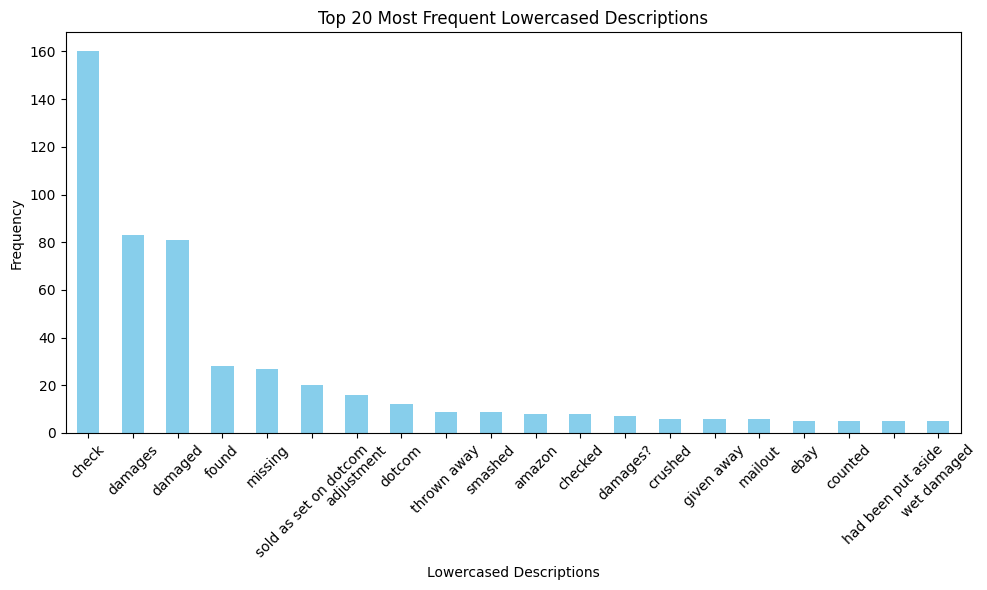

In [1146]:
# # Sort the phrases by count in descending order
descriptions_lower = retail_data[retail_data['description'].apply(lambda t: t.islower())]['description'].value_counts()

# # Plot the histogram
plt.figure(figsize=(10, 6))
descriptions_lower[:20].plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Frequent Lowercased Descriptions')
plt.xlabel('Lowercased Descriptions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1147]:
# Determine proportion of lowercased descriptions visible in histogram
count_lower_descriptions = descriptions_lower[:20].sum()
proportion_lower_descriptions = round(100*(count_lower_descriptions / 725), 2)
print(f'The total number of lowercased descriptions in our histogram is {count_lower_descriptions}, making up\n{proportion_lower_descriptions}% of all lowercased descriptions.')

The total number of lowercased descriptions in our histogram is 506, making up
69.79% of all lowercased descriptions.


Looking at this histogram, the majority of these lowercase listings indicate that a product was either damaged, missing, or categorized as something else. There are so few of these instances though that it is best to just remove them given that we have 1M+ rows of data to work with in total.

In [1148]:
# Remove the lowercase descriptions from the original DataFrame
retail_data = retail_data[~retail_data['description'].apply(lambda t: t.islower())]

In [1196]:
new_lower_count = retail_data['description'].apply(lambda t: t.islower()).sum()
print(f'The new count of lowercase descriptions is {new_lower_count}')

The new count of lowercase descriptions is 0


## Feature Engineering
---

First off, we need to create the value we are going to be forecasting - revenue. Recall from any economics class:  
$$
Revenue = Price * Quantity
$$

In [1149]:
# Create a revenue value
retail_data["revenue"] = round(retail_data["price"] * retail_data["quantity"], 2)

In [1150]:
# Preview data with added 'revenue' column
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


Looking at our dataset, there are four feature changes I want to make: `price`, `invoice_date`, `quantity`, and `description`. I plan on categorizing `quantity` and `price` by using 'low', 'medium', and 'high' bins and breaking `invoice_date` by months so I can get a general trend of how seasonality influences sales. I also plan on using clustering to categorize the `description` feature.  

Before doing any bucketing, we need to make sure that our continuous variables `price` and `quantity` are normally distributed first.

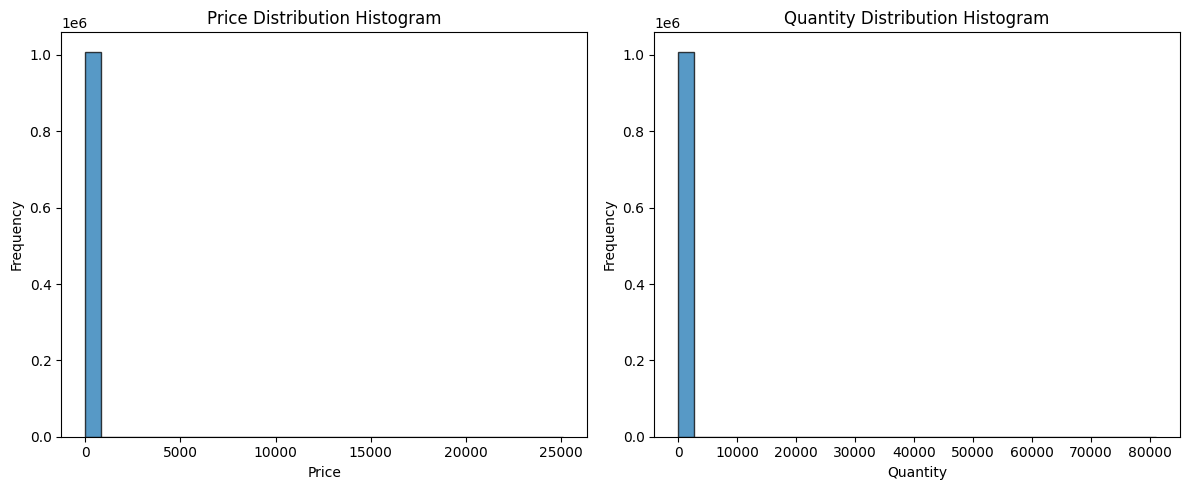

In [1151]:
import matplotlib.pyplot as plt

# Set the figure size and create subplots
plt.figure(figsize=(12, 5))

# Create a subplot for the 'price' variable
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.hist(retail_data['price'], bins=30, edgecolor='k', alpha=0.75)
plt.title('Price Distribution Histogram')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Create a subplot for the 'quantity' variable
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.hist(retail_data['quantity'], bins=30, edgecolor='k', alpha=0.75)
plt.title('Quantity Distribution Histogram')
plt.xlabel('Quantity')
plt.ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()


These histograms indicate that both of our `quantity` and `price` variables are very skewed with most of the distbituion lying near zero. This indicates that there are most likely outliers causing this skew.

Now we will make a scatterplot to see how many outliers there are and whether or not removing them makes a significant difference to our distribution.

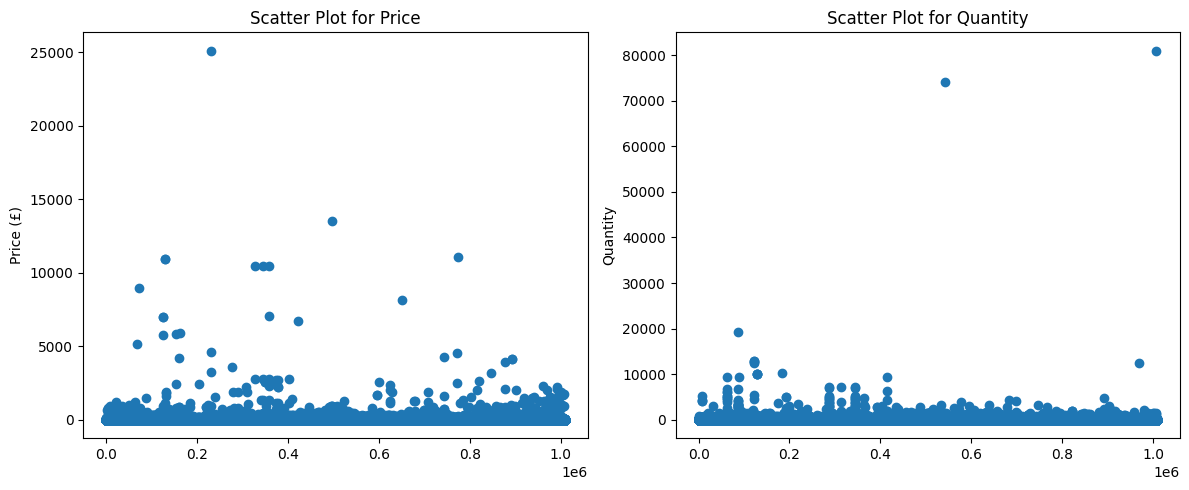

In [1152]:
# Create a Scatter plot figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot 'price' (scatter plot) on the first subplot
ax1.scatter(range(len(retail_data['price'])), retail_data['price'])
ax1.set_title('Scatter Plot for Price')
ax1.set_ylabel('Price (£)')  # Set the y-label for the first subplot

# Plot 'quantity' (scatter plot) on the first subplot
ax2.scatter(range(len(retail_data['quantity'])), retail_data['quantity'])
ax2.set_title('Scatter Plot for Quantity')
ax2.set_ylabel('Quantity')  # Set the y-label for the second subplot

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

Though there are outliers in both the `price` and `quantity` variables, I think that it is reasonable for a store to sell very high priced items and high quantities because they are selling to wholesalers, retail stores, and resellers who can definitely afford to buy this kind of quantity and price.  

Next, we'll check to see the exact records where the `price` was greater than 20,000£ and separately where `quantity` was greater than 60,000

In [1153]:
# Looking at specific instances of our continuous outliers for price and quantity
outliers_df = retail_data[(retail_data['quantity']>60000) | (retail_data['price']>20000)]
outliers_df.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue
241827,512771,M,Manual,1.0,2010-06-17 16:53:00,25111.09,Not Provided,United Kingdom,25111.09
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215.0,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995.0,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60


These outliers seem reasonable. The most expensive item is labeled 'Manual' for the stock code and this indicates in the context of e-commerce or retail data that the particular item doesn't have an automated stock code and was either a unique or custom product or a non-inventory item. The other two outliers were bought in massive quantities but is not surprisinig because of the clientele of this U.K. based store.  

Because these outliers do not seem like mistakes we are going to adjust this distribution with a log to try to make the distribution more normal for categorical binning later.

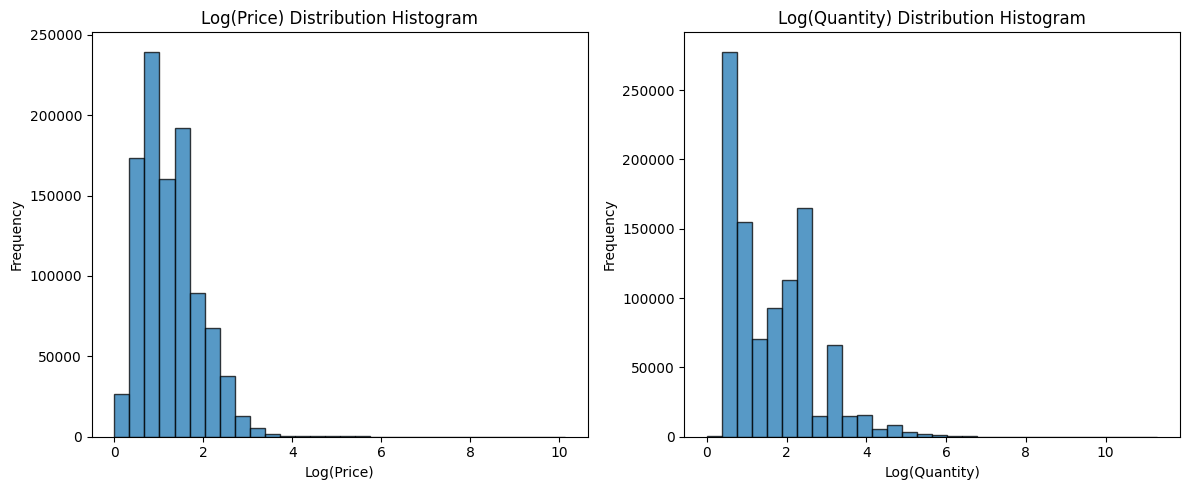

In [1154]:
# Apply the natural logarithm to 'quantity' and 'price'
log_quantity = np.log1p(retail_data['quantity'])  # Add 1 to avoid log(0)
log_price = np.log1p(retail_data['price'])  # Add 1 to avoid log(0)

# Set the figure size and create subplots
plt.figure(figsize=(12, 5))

# Create a subplot for the 'log(price)' variable
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.hist(log_price, bins=30, edgecolor='k', alpha=0.75)
plt.title('Log(Price) Distribution Histogram')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

# Create a subplot for the 'log(quantity)' variable
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.hist(log_quantity, bins=30, edgecolor='k', alpha=0.75)
plt.title('Log(Quantity) Distribution Histogram')
plt.xlabel('Log(Quantity)')
plt.ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

The distribution is still slightly right skewed for both Log(Price) and Log(Quantity) but not nearly as extreme before we applied a log transformation. This will make our binning much easier (and less skewed) when trying to make these variables categorical so we will create new log transformed variables of `price` and `quantity`.

In [1155]:
# Create new log transformed variables of 'price' and 'quantity'
retail_data['log_price'] = np.log1p(retail_data['price'])
retail_data['log_quantity'] = np.log1p(retail_data['quantity'])

# To stay consistent, we will also create a log transformed 'revenue' variable
retail_data['log_revenue'] = np.log1p(retail_data['revenue'])

In [1156]:
# Check to make sure our new variables look how we expect
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,log_price,log_quantity,log_revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2.073172,2.564949,4.435567
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,1.131402,3.891820,4.623010
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,0.810930,3.218876,3.433987


In [1157]:
# Get summary statistics of continuous features
retail_data.describe()

,quantity,invoice_date,price,revenue,log_price,log_quantity,log_revenue
count,1.008932e+06,1008932,1.008932e+06,1.008932e+06,1.008932e+06,1.008932e+06,1.008932e+06
mean,1.115949e+01,2011-01-04 10:11:41.637573888,4.070137e+00,2.029499e+01,1.253749e+00,1.720367e+00,2.358967e+00
min,0.000000e+00,2009-12-01 07:45:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2010-07-06 11:21:00,1.250000e+00,4.130000e+00,8.109302e-01,6.931472e-01,1.635106e+00
50%,4.000000e+00,2010-12-09 15:23:00,2.100000e+00,1.008000e+01,1.131402e+00,1.609438e+00,2.405142e+00
75%,1.200000e+01,2011-07-28 11:29:00,4.130000e+00,1.770000e+01,1.635106e+00,2.564949e+00,2.928524e+00
max,8.099500e+04,2011-12-09 12:50:00,2.511109e+04,1.684696e+05,1.013110e+01,1.130216e+01,1.203452e+01
std,1.296109e+02,NaN,5.040515e+01,2.056129e+02,6.457492e-01,9.973460e-01,1.011556e+00


Our continuous variables `log_quantity` and `log_price` are fairly well spread out across all quartiles. Here, it makes no sense to look at the summary statistics of `invoice_date` for binning so we'll ignore that for now.  

`log_quantity`: 
* Min: 0.00 log(items) 
* 25th percentile: 0.69 log(items)
* 50th percentile (median): 1.61 log(items)
* 75th percentile: 2.56 log(items)
* Max: 11.31 log(items)

`log_price`:
* Min: 0.00 log(£)
* 25th percentile: 0.81 log(£)
* 50th percentile (median): 1.13 log(£)
* 75th percentile: 1.64 log(£)
* Max: 10.58 log(£)

<u>*Approach*</u>: 
* 'low': Values between the 25th and 50th percentile (Q1 to Q2)
* 'medium': Values between the 50th and 75th percentile (Q2 to Q3)
* 'high': Values greater than or equal to the 75th percentile (Q3)


In [1158]:
# Define the bin edges and labels for 'quantity' and 'price'
log_quantity_bin_edges = [0, 0.69, 1.61, 2.56, 11.31]
log_price_bin_edges = [0, 0.81, 1.13, 1.64, 10.58]
log_quantity_bin_labels = ["very_low_quantity", "low_quantity", "medium_quantity", "high_quantity"]
log_price_bin_labels = ["very_low_price", "low_price", "medium_price", "high_price"]

# Use pd.cut() to categorize the 'quantity' and 'price' columns
retail_data["quantity"] = pd.cut(
    retail_data["log_quantity"],
    bins=log_quantity_bin_edges,
    labels=log_quantity_bin_labels,
    include_lowest=True,
)
retail_data["price"] = pd.cut(
    retail_data["log_price"],
    bins=log_price_bin_edges,
    labels=log_price_bin_labels,
    include_lowest=True,
)

Though it seems strange to use a different number of bins for `quantity` and `price`, I think that it is justified to use one extra bin of 'very_low' for price because a price can be fractions of a pound but we assuume a quantity cannot be fractional. Because the minimum and 25th percentile are both 1, we lose a bin as well for `quantity` 

In [1159]:
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,log_price,log_quantity,log_revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,2.073172,2.564949,4.435567
1,489434,79323P,PINK CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719
2,489434,79323W,WHITE CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,medium_price,13085.0,United Kingdom,100.8,1.131402,3.891820,4.623010
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,30.0,0.810930,3.218876,3.433987


In [1160]:
retail_data[retail_data["quantity"].isna()==True]

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,log_price,log_quantity,log_revenue


In [1161]:
# Check for missing values after binning in 'quantity'
quantity_counts_na = retail_data["quantity"].isna().sum()
print(f"There are {quantity_counts_na} missing values for the `quantity` column.")

# Check for missing values after binning in 'price'
price_counts_na = retail_data["price"].isna().sum()
print(f"There are {price_counts_na} missing values for the `price` column.")

There are 0 missing values for the `quantity` column.
There are 0 missing values for the `price` column.


Looking better. Now, let's create a variable called `month` so that in addition to the datetime timestamp, we can also analyze how customer behavior changes by month/season.

In [1162]:
# Create a new 'month' column
retail_data["month"] = retail_data["invoice_date"].dt.strftime("%B")

In [1163]:
# Preview updated dataframe
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,log_price,log_quantity,log_revenue,month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,2.073172,2.564949,4.435567,December
1,489434,79323P,PINK CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719,December
2,489434,79323W,WHITE CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,2.047693,2.564949,4.406719,December
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,medium_price,13085.0,United Kingdom,100.8,1.131402,3.891820,4.623010,December
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,30.0,0.810930,3.218876,3.433987,December


Now, let's take a look at our distribution for `country` and see if we need to do any modifications.

In [1164]:
# Looking at our distribution of country
country_counts = retail_data["country"].value_counts()
print(country_counts)

country
United Kingdom          927030
EIRE                     17159
Germany                  16440
France                   13640
Netherlands               5090
Spain                     3663
Switzerland               3123
Belgium                   3056
Portugal                  2470
Australia                 1792
Channel Islands           1551
Italy                     1442
Sweden                    1336
Norway                    1290
Cyprus                    1136
Finland                   1032
Austria                    922
Denmark                    778
Unspecified                748
Greece                     657
Poland                     504
Japan                      468
United Arab Emirates       467
USA                        409
Israel                     366
Hong Kong                  354
Singapore                  339
Malta                      282
Canada                     228
Iceland                    222
RSA                        168
Lithuania                  154


In [1165]:
# Calculate the proportion of U.K. countries for all recorded transactions
prop_uk = country_counts = round(100*(retail_data["country"].value_counts().iloc[0] / retail_data["country"].value_counts().sum()), 2)
print(f'The U.K. makes up {prop_uk}% of all country entries.')

The U.K. makes up 91.88% of all country entries.


Immediately, we see that the overwhelming majority is U.K. (91.88%) To make things simpler for our model in the future, we are going to just drop all non-U.K. countries because it is unlikely they will influence our clusters or timeseries forecasting later on.

In [1166]:
# Dropping all rows in 'country' not equal to "United Kingdom"
retail_data = retail_data[retail_data['country'].str.lower() == 'United Kingdom'.lower()]
print(retail_data.shape)

(927030, 13)


After dropping non-U.K. countries, we have less than a million rows.

### Topic Modeling `description` with Top2Vec vs LDA (gensim) 

#### Top2Vec

In [1167]:
# Let's determine the total number of documents in our corpus along with
unique_descriptions = retail_data["description"].nunique()
avg_doc_len = np.mean(
    [len(d.split()) for d in retail_data["description"].unique().tolist()]
).round()
print(f"There are {unique_descriptions} unique descriptions in out dataset.")
print(f"Each description has an average of {avg_doc_len} words.")

There are 5454 unique descriptions in out dataset.
Each description has an average of 4.0 words.


Our data now has more categorical features. One issue we may face in the future is our `description` variable having so many unique descriptions (5399). With all of these descriptions it will be very difficult to make any meaningful model unless we categorize them. We will first try do this with Topic Modeling via the *Top2Vec* library. I do have some doubts though just because there are only 5399 descriptions, each with an average of ~4 words. It will definitely be difficult to generalize.

In [1168]:
# Create list of descriptions
unique_docs = retail_data["description"].unique().tolist()

In [1169]:
# Instantiate/train Top2Vec model
# model = Top2Vec(unique_docs)
# Save model
# model.save(
#     r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\models\t2v"
# )

In [1170]:
# Load in model trained on 30% of total documents
model = Top2Vec.load(
    r"C:\Users\evans\OneDrive\Desktop\DS4A\data_scientist_retail_challenge\retail-customer-segmentation-forecasting\models\t2v"
)

In [1171]:
# Grab the size and number of all of our topics
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)

[272 264 264 263 253 251 247 240 240 238 237 234 233 232 227 226 220 218
 215 214 205 204 202]


`topic_sizes` shows us the amount of documents that correspond to each topic where each index in this list is an individual topic ordered from topics with the most documents to fewest documents at the end of the list.

In [1172]:
print(topic_nums)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


`topic_nums` simply displays the index numbers sequentially. Here, we can see that we have 23 unique topics in our model.

In [1173]:
# Rank top 5 topics on most common to least common basis
topic_words, word_scores, topic_nums = model.get_topics(3)

In [1174]:
# Iterate over these three outputs
for words, scores, num in zip(topic_words, word_scores, topic_nums):
    print(num)
    print(f"Words: {words}")

0
Words: ['in' 'bottle' 'of' 'cake' 'ring' 'rose' 'pink' 'black' 'cards' 'small'
 'and' 'earrings' 'bowl' 'candles' 'love' 'enamel' 'wall' 'gift' 'cushion'
 'paper' 'ceramic' 'crystal' 'easter' 'tile' 'green' 'hanging' 'spotty'
 'cutlery' 'gold' 'assorted' 'art' 'silver' 'bag' 'purple' 'cover' 'egg'
 'fairy' 'polkadot' 'design' 'sign' 'mug' 'zinc' 'star' 'cream' 'tea'
 'door' 'retro' 'holder' 'round' 'card']
1
Words: ['card' 'of' 'hanging' 'tree' 'frame' 'blue' 'fairy' 'black' 'cake'
 'clock' 'spot' 'assorted' 'green' 'cards' 'mini' 'glass' 'tile'
 'retrospot' 'and' 'decoration' 'heart' 'pack' 'girl' 'cover' 'flower'
 'retro' 'candle' 'mirror' 'door' 'vintage' 'wooden' 'lights' 'art'
 'photo' 'paper' 'metal' 'crystal' 'holder' 'wrap' 'garden' 'silver'
 'cutlery' 'wall' 'bottle' 'ring' 'rose' 'bowl' 'in' 'christmas' 'cushion']
2
Words: ['bottle' 'retro' 'tree' 'bird' 'ceramic' 'red' 'enamel' 'round' 'star'
 'and' 'cushion' 'ring' 'earrings' 'crystal' 'white' 'home' 'easter'
 'sign' 'gar

Let's just look at topic one right now. We are going to look at topic one and the documents that correspond to it.

In [1175]:
# Grab corresponding top 10 documents for topic one
documents, document_scores, document_ids = model.search_documents_by_topic(
    topic_num=0, num_docs=3
)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("--------------")
    print(doc)
    print("--------------")
    print()

Document: 5077, Score: 0.2994881272315979
--------------
HOME SWEET HOME CUSHION COVER 
--------------

Document: 5339, Score: 0.27533596754074097
--------------
SET 10 CARD SNOWMAN 16965
--------------

Document: 4339, Score: 0.26661357283592224
--------------
T-LIGHT HOLDER SWEETHEART HANGING
--------------



These cosine similarities are very low and indicate weak or no similarity between our documents and the topics we classified. This is really no surprise since we have such few documents (<6000) with the average length of 4 words per document.  

However, the main metric that topic models tend to use is the CV Coherence score - a measure used to evaluate the quality of topics generated by a topic modeling algorithm. It asseses how well the words within a topic are related and how distinct different topics are from each other (the higher the score, the more coherent the topics). Analytically, this is the normalized NPMI (Normalized Pointwise Mutual Information) and cosine similarity.  

$$
C_V = \frac{\sum_{i < j} \text{score}(w_i, w_j)}{\sum_{i < j} \text{normalization}(w_i, w_j)}
$$

Here, $w_i$ and $w_j$ are words, and the function $text{score}(w_i, w_j)$ and $text{normalization}(w_i, w_j)$ contribute to the score and normalization, respectively. The summations are over all pairs of words $i$ and $j$ $(i < j)$ in the set of top words for each topic.  

The specific formulas for $text{score}(w_i, w_j)$ uses cosine similarity:

$$
\text{Cosine Similarity} = \frac{{w_i \cdot w_j}}{{\|w_i\| \cdot \|w_j\|}}
$$

In [1176]:
# Compute the NPMI (Normalized Pointwise Mutual Information) Coherence Score for Top2Vec
compute_cv_coherence(model, unique_docs)

0.0

Using my handcrafted formula for Coherence CV score (see `top2vec_utils.py`) indicates that our score is ~0 and there is little to no semantic coherence among the rop words in the topics genreated by our Top2Vec topic model. This could be because of a number of reasons but is probably mainly due to a short corpus size and how Top2Vec is configured.

#### LDA (gensim)

To get a variety of topic modeling outputs, we are also going to test gensim's LDA model on our descriptions.

In [1177]:
# Create list of Stop words using NLTK
stop_words = stopwords.words("english")
stop_words.extend(["from", "subject", "re", "edu", "use", "cm", "ft"])

In [1178]:
# Tokenize each sentence into a list of words using simple_preprocess (gensim)
data_words = list(sent_to_words(unique_docs))
print(data_words[:1])

[['cm', 'christmas', 'glass', 'ball', 'lights']]


In [1179]:
# Create bigram and trigram models using gensim's Phrases model
bigram = Phrases(data_words, min_count=1, threshold=2)
trigram = Phrases(bigram[data_words], threshold=2)

# Use the 'Phraser' class from gensim to apply bigram/trigram models in memory-effieicent way
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['cm', 'christmas', 'glass_ball', 'lights']


In [1180]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words, stop_words=stop_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod=bigram_mod)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
#nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(
    data_words_bigrams, nlp=nlp, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]
)

In [1181]:
# Preview the first element of data_lemmatized
print(data_lemmatized[:1])

[['light']]


The two main inputs to the gensim LDA topic model are the dictionary (id2word) and the corpus. Let's create them.

In [1182]:
# Create a dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[(0, 1)], [(1, 1), (2, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).  For example, (0,1) above implies that word id 0 occurs once in the first document, word id 1 occurs once as well. Since our documents are so shorty, each element of corpus will only contain a few (word_id, word_frequency) tuples.

<u>Building the Topic Model</u>

  Parameters: `alpha` and `eta` - hyperparameters that affect the sparsity of the topics. `chunksize` - the number of documents to be used in each training chunk. `update_every` - determines how often the model parameters should be updated. `passes` is the total number of training passes.

In [1183]:
# Build LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=42,
    update_every=1,
    passes=10,
    alpha="auto",
    per_word_topics=True,
)

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. We will now look at the weightage (importance) of each keyword using `lda_model.print_topics()` 

In [1184]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.051*"rise" + 0.045*"star" + 0.034*"tin" + 0.031*"cream" + 0.022*"pink_polkadot" + 0.021*"paper_lantern" + 0.019*"butterfly" + 0.017*"purse" + 0.010*"girl" + 0.010*"notebook"'), (1, '0.060*"design" + 0.056*"vintage" + 0.026*"dolly_girl" + 0.024*"hook" + 0.022*"pantry" + 0.018*"travel_card" + 0.018*"mirror" + 0.016*"mini" + 0.015*"wall_art" + 0.015*"pink"'), (2, '0.162*"pink" + 0.104*"blue" + 0.052*"white" + 0.047*"black" + 0.013*"bag" + 0.012*"french" + 0.010*"earring" + 0.009*"spot" + 0.009*"cover" + 0.008*"photo_frame"'), (3, '0.210*"set" + 0.093*"heart" + 0.059*"flower" + 0.028*"bottle" + 0.017*"hot_water" + 0.013*"basket" + 0.013*"garden" + 0.009*"doily" + 0.009*"beaker" + 0.009*"charm"'), (4, '0.089*"red" + 0.077*"small" + 0.048*"light" + 0.047*"set" + 0.032*"mug" + 0.032*"silver" + 0.016*"vintage" + 0.015*"vintage_doily" + 0.011*"coaster" + 0.011*"pen"'), (5, '0.094*"large" + 0.085*"candle" + 0.021*"bowl" + 0.020*"metal" + 0.020*"home" + 0.019*"letter_ble" + 0.019*"key_rin

How to interpret?  
Topic 0 is represented as '0.043*"white" + 0.029*"mirror" + 0.026*"cream" + 0.025*"heart" + 0.022*"vintage" + 0.020*"garden" + 0.020*"assort" + 0.018*"rabbit" + 0.018*"pink" + 0.016*"round"  

This means that the top 10 keywords that contribute to this topic are: 'white', 'mirror', 'cream'... and so on and the weight of 'white' on topic 0 is 0.043  

Looking at these keywords in the context of gifts, category one might be 'Vintage-inspired Home Decor'.



Compute Model Perplexity and Coherence Score  
Model preplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [1185]:
# Compute Perplexity
print(
    f"Perplexity: {lda_model.log_perplexity(corpus)}"
)  # A measure of how good the model is - the lower the  better

# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence="c_v"
)
coherence_lda = coherence_model_lda.get_coherence()
print(f"\nCoherence Score: {coherence_lda}")

Perplexity: -7.9750444211319245

Coherence Score: 0.7070839106221978


Here, we get a coherence score of ~0.71 when using 10 topics.  

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. We will use pyLDAvis package's interactive chart. 

In [1186]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.059098 -0.269502       1        1  13.667665
3     -0.292632  0.018278       2        1  13.105638
4     -0.182971  0.026396       3        1  10.913162
7      0.086608  0.055684       4        1   9.456370
6      0.096138  0.134281       5        1   9.396796
1      0.014384 -0.153004       6        1   9.337831
9      0.078752 -0.018619       7        1   8.797380
5      0.052462  0.077827       8        1   8.767670
8      0.064815  0.119453       9        1   8.388286
0      0.023346  0.009206      10        1   8.169204, topic_info=         Term        Freq       Total Category  logprob  loglift
41        set  358.000000  358.000000  Default  30.0000  30.0000
2        pink  267.000000  267.000000  Default  29.0000  29.0000
54       blue  156.000000  156.000000  Default  28.0000  28.0000
29      heart  134.000000  134.000000  Default  27.0000  27.0000
111       red  106.000000  106.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
192      girl    9.245564   13.469692  Topic10  -4.5712   2.1285
415  notebook    8.975851   13.023454  Topic10  -4.6008   2.1326
97        toy    5.324167    7.044158  Topic10  -5.1231   2.2249
147      lamp    6.289397    9.658082  Topic10  -4.9565   2.0759
559  assorted    6.577458   13.907833  Topic10  -4.9117   1.7560

[396 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
2218      1  0.954600  acrylic_edwardian
1339      3  0.889348      acrylic_jewel
1367      3  0.968610        alarm_clock
299       1  0.969696           alphabet
1595      1  0.865869              amber
...     ...       ...                ...
338       6  0.174312             yellow
338       8  0.116208             yellow
464       3  0.228372               zinc
464       5  0.570929               zinc
464       9  0.171279               zinc

[418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 8, 7, 2, 10, 6, 9, 1])

<u>How to infer pyLDAvis's output</u>  

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent the topic. Ideally, a good topic model will have fairly large, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.  

A model that has too many topics will typically have many overlaps, small sized bubbles clustered in one region of the chart.


<u>Finding the optimal number of topics for LDA</u>  

Next, we will find the optimal number of topics by building many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.   

Choosing a k value that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value cna sometimes provide more granular subtopics. If we see repeated keywords in multiple topics, it probably means our k is too large.  

We will create a `compute_coherence_values()` function that trains multiple LDA models and provides the models and their corresponding coherence scores.

In [1187]:
# This might take a long time to run...
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=data_lemmatized,
    start=2,
    limit=40,
    id2word=id2word,
    step=6,
)

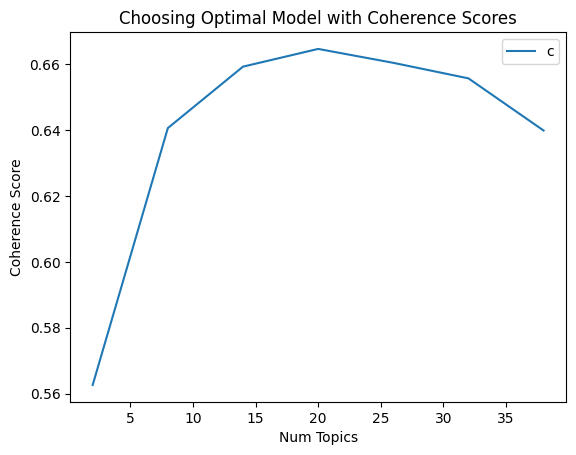

In [1188]:
# Show graph
limit = 40
start = 2
step = 6
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.title("Choosing Optimal Model with Coherence Scores")
plt.show()

In [1189]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5626
Num Topics = 8  has Coherence Value of 0.6407
Num Topics = 14  has Coherence Value of 0.6593
Num Topics = 20  has Coherence Value of 0.6647
Num Topics = 26  has Coherence Value of 0.6605
Num Topics = 32  has Coherence Value of 0.6557
Num Topics = 38  has Coherence Value of 0.6399


Because the delta of coherence value from 2 topics to 8 topics is the largest, we are going to use 8 topics. Even though higher numbers of topics have a slightly higher coherence score (~0.2 higher), adding 6-18 more topics of complexity to our forecasting model later on is not worth it for such a small gain in coherence.

In [1190]:
# Select the optimal model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=30))

[(0, '0.033*"polkadot" + 0.026*"heart" + 0.026*"star" + 0.023*"cream" + 0.023*"small" + 0.021*"set" + 0.020*"rise" + 0.019*"glass" + 0.018*"pink" + 0.015*"jar" + 0.013*"sticker" + 0.011*"blue_polkadot" + 0.011*"cake" + 0.010*"flower" + 0.009*"girl" + 0.009*"playing_card" + 0.009*"tea" + 0.008*"pad" + 0.008*"assorted" + 0.008*"purse" + 0.008*"vintage" + 0.007*"game" + 0.007*"butterfly" + 0.007*"blue" + 0.007*"balloon" + 0.006*"leaf" + 0.006*"paper_lantern" + 0.006*"mug" + 0.006*"blue_felt" + 0.006*"list"'), (1, '0.055*"design" + 0.042*"retrospot" + 0.029*"pantry" + 0.024*"pink" + 0.021*"dolly_girl" + 0.020*"set" + 0.020*"mirror" + 0.018*"hook" + 0.013*"heart" + 0.012*"kit" + 0.012*"container" + 0.011*"ribbon_reel" + 0.011*"vintage" + 0.010*"alarm_clock" + 0.010*"egg" + 0.009*"decoration" + 0.008*"christmas_tree" + 0.008*"tier" + 0.007*"cabinet" + 0.007*"skull" + 0.007*"antique_white" + 0.007*"clear" + 0.007*"candle_holder" + 0.006*"rustic" + 0.005*"pin_cushion" + 0.005*"tidy" + 0.005*"p

In [1191]:
# Visualize the topics in the optimal lda model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.140854  0.032260       1        1  15.809428
2      0.036106 -0.020994       2        1  14.137839
4     -0.079595 -0.176937       3        1  13.996360
0     -0.125132  0.006825       4        1  12.454236
7      0.223947 -0.054141       5        1  11.396731
1      0.020840  0.023123       6        1  11.082482
5      0.018435  0.182123       7        1  10.805181
6      0.046253  0.007741       8        1  10.317744, topic_info=       Term        Freq       Total Category  logprob  loglift
41      set  399.000000  399.000000  Default  30.0000  30.0000
13    large  108.000000  108.000000  Default  29.0000  29.0000
111     red  115.000000  115.000000  Default  28.0000  28.0000
11   design   78.000000   78.000000  Default  27.0000  27.0000
210  candle   81.000000   81.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
49    frame    6.490844   26.919218   Topic8  -5.1585   0.8489
85   holder    7.127529   53.340534   Topic8  -5.0649   0.2586
162   glass    6.687526   52.303225   Topic8  -5.1286   0.2145
273    hook    6.410859   34.199346   Topic8  -5.1709   0.5971
54     blue    6.370108  153.681994   Topic8  -5.1773  -0.9120

[421 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1339      1  0.890249  acrylic_jewel
1367      6  0.956734    alarm_clock
299       1  0.936656       alphabet
576       5  0.856127         animal
229       3  0.731754        antique
...     ...       ...            ...
464       1  0.049095           zinc
464       2  0.049095           zinc
464       3  0.245474           zinc
464       8  0.589138           zinc
86        2  0.778900     zinc_light

[736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 1, 8, 2, 6, 7])

<u>Find the dominant in each sentence</u>  

Now, we need to determine what topic a given document is about. To do this, we find the topic number that has the highest percentage contribution in that document. The `format_topics_sentences()` function nicely aggregates this information in a presentable table.

In [1192]:
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model, corpus=corpus, texts=unique_docs
)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.5624,"red, vintage, sign, small, set, light, pink, m...",15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,1,5,0.7077,"large, candle, doormat, key_ring, letter_ble, ...",PINK CHERRY LIGHTS
2,2,0,0.1250,"polkadot, heart, star, cream, small, set, rise...",WHITE CHERRY LIGHTS
3,3,3,0.7811,"set, heart, flower, pink, pink_polkadot, bottl...","RECORD FRAME 7"" SINGLE SIZE"
4,4,5,0.5619,"large, candle, doormat, key_ring, letter_ble, ...",STRAWBERRY CERAMIC TRINKET BOX
5,5,2,0.7082,"pink, blue, white, decoration, black, holder, ...",PINK DOUGHNUT TRINKET POT
6,6,6,0.5386,"green, silver, necklace, tin, cutlery, pink, b...",SAVE THE PLANET MUG
7,7,0,0.1250,"polkadot, heart, star, cream, small, set, rise...",FANCY FONT HOME SWEET HOME DOORMAT
8,8,0,0.1250,"polkadot, heart, star, cream, small, set, rise...",CAT BOWL
9,9,1,0.5625,"design, retrospot, pantry, pink, dolly_girl, s...","DOG BOWL , CHASING BALL DESIGN"


This on its own is still pretty difficult to interpret (topic keywords may not be enough to make sense of what the topic is about) So, to help with understanding the topic, we can find the documents a given topic has contributed to the most and infer the ropic by reading that document. 

In [1193]:
# Group the top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_grouped = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in sent_topics_grouped:
    sent_topics_sorted = pd.concat(
        [
            sent_topics_sorted,
            grp.sort_values(["Perc_Contribution"], ascending=[0]).head(1),
        ],
        axis=0,
    )

# Reset Index
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ["Topic_Num", "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorted

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.8541,"polkadot, heart, star, cream, small, set, rise...","BROCADE PURSE,SMALL ARCH BUTTON"
1,1,0.8541,"design, retrospot, pantry, pink, dolly_girl, s...","MERCHANT CHANDLER CREDIT ERROR, STO"
2,2,0.8748,"pink, blue, white, decoration, black, holder, ...",SET/6 BEAD COASTERS GAUZE BAG GOLD
3,3,0.8540,"set, heart, flower, pink, pink_polkadot, bottl...",CREAM CUPID HEARTS COAT HANGER
4,4,0.8541,"red, vintage, sign, small, set, light, pink, m...",SET OF 10 LANTERNS FAIRY LIGHT STAR
5,5,0.8250,"large, candle, doormat, key_ring, letter_ble, ...",UNION JACK GUNS & ROSES DOORMAT
6,6,0.8250,"green, silver, necklace, tin, cutlery, pink, b...",WOOD XMAS TREE 9 FIG SHELVES
7,7,0.8539,"card, pack, wrap, tissue, gold, box, ivory, st...",LETS GO SHOPPING COTTON TOTE BAG


In [1194]:
for idx, kw in enumerate(sent_topics_sorted.Keywords):
    print(idx, kw)
    print("---")

0 polkadot, heart, star, cream, small, set, rise, glass, pink, jar
---
1 design, retrospot, pantry, pink, dolly_girl, set, mirror, hook, heart, kit
---
2 pink, blue, white, decoration, black, holder, bunny, set, home, bag
---
3 set, heart, flower, pink, pink_polkadot, bottle, plate, light, garden, tree
---
4 red, vintage, sign, small, set, light, pink, mug, reel, silver
---
5 large, candle, doormat, key_ring, letter_ble, pink, magnet, assort, rose, earring
---
6 green, silver, necklace, tin, cutlery, pink, bell, napkin, shelf, dotcom
---
7 card, pack, wrap, tissue, gold, box, ivory, stand, drawer, decoration
---


<u>Rationale for Classifications</u>  

<u>*Topic 0*:</u>  

1. Color Palette: The presence of words like "white," "silver," "cream," and "pink" suggests a focus on color, which is often associated with home decor and accessories.

1. Home-related Items: Words like "doormat," "cup," and "sticker" are often associated with items found in homes.

1. Garden Element: The word "garden" suggests a connection to outdoor or garden-related items, which can still fall under the broader category of home decor.

1. Set: The term "set" might indicate that these items are sold together as part of a collection, common in the context of home decor.

1. Heart: The word "heart" might be associated with decorative elements or items related to love and sentiment, fitting well with the theme of unique gifts.

Given these observations, the predicted category is "Home Decor and Accessories," where the company likely specializes in providing unique and stylish items for home decoration and personal use.

Predicted category: **Home Decor and Accessories**  

<u>*Topic 1*:</u>  

1. Color Palette: The words "red_retrospot," "vintage," "black," "blue_polkadot," and "pink" indicate a specific color palette associated with vintage and retro aesthetics.

1. Materials: The presence of "tin" and "metal" suggests items made from these materials, commonly used in crafting vintage-style decor.

1. Home Decor Elements: The words "frame," "clock," and "bucket" are indicative of home decor and accessories. Frames and clocks are classic decorative items, while a "tin seaside bucket" aligns with vintage-themed decor.

1. Sentimental Touch: The term "sweetheart" implies items with a sentimental or romantic touch, fitting well within the category of unique gifts.

1. Representative Sentence: The sentence "GIRLS VINTAGE TIN SEASIDE BUCKET" contains keywords like "vintage," "tin," and "seaside," reinforcing the association with vintage-inspired and coastal-themed decor.

Predicted category: **Vintage Home Decor and Accessories**  

<u>*Topic 2*:</u>  

1. Crafting and Design Elements: Keywords like "design," "large," "holder," and "set" suggest items related to crafting and design. The mention of "ribbon_reel" and "bunny" further emphasizes the creative and decorative nature of these items.

1. Decorative Themes: Terms such as "decoration," "dolly_girl," "ivory," and "hanging_heart" point towards decorative elements with a focus on aesthetics and design.

1. Artistic Touch: The inclusion of "bunny" implies a cute or whimsical aspect, aligning with artistic and creative themes commonly found in unique gifts.

1. Representative Sentence: The sentence "SET 12 RETRO WHITE CHALK STICKS" includes keywords like "set," "retro," and "white chalk sticks," suggesting artistic materials or decorative craft supplies.

Predicted category: **Artistic and Decorative Craft Supplies**  

<u>*Topic 3*:</u>  

1. Set: The term "set" suggests that the items are sold together as a collection or grouping. This could include multiple candles along with additional components.

1. Red: The color "red" indicates a specific color theme for the items. This suggests that the candles or related items are predominantly red in color.

1. Candle: The presence of the word "candle" indicates that the items are indeed related to candles. This aligns with the theme of a candle set.

1. Polkadot, Ceramic, Gold: These words provide additional characteristics of the items. "Polkadot" suggests a pattern, "ceramic" indicates a possible material, and "gold" may be a color or accent.

1. Light: The term "light" may emphasize that these items are associated with lighting, confirming the focus on candles.

1. Tray, Mini, Beaker: These words suggest additional accessories or components that may accompany the candle set, such as a tray, mini items, or a beaker.

Predicted category: **Decorative or Themed Candle Set**

<u>*Topic 4*:</u>  

1. Small: Indicates that the items are of a small size, possibly decorative or party-related accessories.

1. Retrospot: Suggests a retro or vintage spotted pattern, which is commonly associated with party and decorative items.

1. Pink, Purple: Color indicators. Pink and purple are colors often associated with festive and decorative items, especially in the context of gifts.

1. Bottle: Could refer to decorative bottles, possibly containing party favors or decorative elements.

1. Heart: Implies that some items in this category may have a heart shape, commonly used in decorative and gift-related items.

1. Paper Lantern: A specific item mentioned that is often associated with decorative lighting for parties or events.

1. Gift Bag: Indicates the presence of gift bags, commonly used for packaging small gifts and party favors.

1. Drawer: While less common, the term "drawer" could suggest a decorative drawer or container for storing small items.

1. Hot Water: Although seemingly unrelated, it might be an outlier or part of a specific product name. Alternatively, it could relate to items associated with warm beverages in a festive context.

1. Assorted: The term "assorted" in the most representative sentence suggests a variety of items, reinforcing the idea of a collection of party and decorative items.

Predicted category: **Assorted Party and Decorative Items**  

<u>*Topic 5*:</u>   

1. Green, Pink: Color indicators. Green and pink are often associated with artistic and vibrant home decor items.

1. Necklace: Indicates the presence of a wearable accessory, possibly a decorative necklace.

1. Hang, Decoration: Suggests items designed for hanging and decoration, aligning with home decor and accessory categories.

1. Plate: Could refer to a decorative plate, commonly used in home decor.

1. Key_Re (Key Ring): While the term is truncated, "key_re" likely refers to a key ring, a small decorative item often associated with home decor and accessories.

1. Wrap: Implies that some items may be gift-worthy or come with decorative packaging.

1. Jar: Might indicate a decorative jar, commonly used for storing small items or as a decorative element.

1. Letter_Ble (Letter B): Possibly indicates a decorative item related to the letter 'B', which could be part of a personalized or alphabet-themed home decor item.

1. Painted Sea Shell Metal Windchime: The most representative sentence provides additional context, suggesting a specific item in the category—painted sea shell metal windchime. Windchimes are often considered decorative and artistic elements for homes.

Predicted category: **Artistic Home Decor and Accessories**  

<u>*Topic 6*:</u>  

1. Heart, Star: These shapes are commonly used in decorative elements for gift wrapping and presentation.

1. Blue, Pink: Colors often associated with various occasions, including those for which gifts are exchanged.

1. Card, Sign: Suggestive of items used for creating personalized gift cards or signs for special occasions.

1. Pack, Set: Indicators of items available in packs or sets, common in gift wrapping materials.

1. Drawer_Knob: While less common, decorative drawer knobs could be used in the context of gift packaging or decorative boxes.

1. Pantry: May suggest items like decorative labels or tags used in gift presentation.

Predicted category: **Retro-inspired Kitchen or Home Decor Gifts**

<u>*Topic 7*:</u>

1. Pink, Blue: Colors commonly associated with home decor and floral arrangements.

1. Flower, Rose: Direct references to floral elements, indicating a focus on botanical or floral-themed items.

1. Box, Cushion Cover: Suggestive of home decor items, such as decorative boxes or cushion covers with floral designs.

1. Rise, Table: Implies items that could be used for tabletop decor, such as flower arrangements or art pieces.

1. Classic: Suggests a timeless and sophisticated style, often associated with artistic and decorative elements in home decor.

1. Home: Indicates items designed for home use or decoration.

1. Paper: Could be related to art prints, floral-themed paper products, or decorative paper used in home decor.

1. MEDIUM WHITE/PINK ROSE ART FLOWER: The most representative sentence aligns with the theme, describing a medium-sized artistic floral arrangement in white and pink.

Predicted category: **Home Decor and Artistic Floral Arrangements**


In [748]:
# Now that we have our categories, let's map them to our descriptions.
categories = {
    0: "Home Decor/Accessories",
    1: "Vintage Home Decor/Accessories",
    2: "Artistic/Decorative Craft Supplies",
    3: "Decorative/Themed Candle Set",
    4: "Assorted Party/Decorative Items",
    5: "Artistic Home Decor/Accessories",
    6: "Retro-inspired Kitchen or Home Decor Gifts",
    7: "Home Decor/Artistic Floral Arrangements",
}

# Get the document-topic distribution
all_topics = optimal_model.get_document_topics(corpus, minimum_probability=0.0)

# Convert the distribution to a DataFrame
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)


# Display the DataFrame
all_topics_df["descriptions"] = unique_docs

# Create a new column with the maximum value and the corresponding column name
all_topics_df["topic"] = all_topics_df.iloc[:, :-1].apply(
    lambda row: row.idxmax(), axis=1
)
all_topics_df["topic"] = all_topics_df["topic"].map(categories)

# Create a dictioanry to map 'descriptions' to keys and 'topic' to values
topic_to_description = all_topics_df.set_index("descriptions")["topic"].to_dict()

In [749]:
all_topics_df.head()

,0,1,2,3,4,5,6,7,descriptions,topic
0,0.041697,0.041690,0.041669,0.041840,0.041858,0.707855,0.041673,0.041719,15CM CHRISTMAS GLASS BALL 20 LIGHTS,Artistic Home Decor/Accessories
1,0.041694,0.041676,0.491706,0.041680,0.041671,0.258154,0.041714,0.041705,PINK CHERRY LIGHTS,Artistic/Decorative Craft Supplies
2,0.292115,0.041686,0.457779,0.041722,0.041671,0.041676,0.041672,0.041680,WHITE CHERRY LIGHTS,Artistic/Decorative Craft Supplies
3,0.041672,0.041828,0.041672,0.041672,0.708139,0.041672,0.041672,0.041672,"RECORD FRAME 7"" SINGLE SIZE",Assorted Party/Decorative Items
4,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,STRAWBERRY CERAMIC TRINKET BOX,Home Decor/Accessories


In [750]:
# Map the topics to descriptions in the main dataframe
retail_data["topic"] = retail_data["description"].map(topic_to_description)

In [751]:
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,canceled,revenue,log_price,log_quantity,log_revenue,month,topic
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,not_canceled,83.4,2.073172,2.564949,4.435567,December,Artistic Home Decor/Accessories
1,489434,79323P,PINK CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,not_canceled,81.0,2.047693,2.564949,4.406719,December,Artistic/Decorative Craft Supplies
2,489434,79323W,WHITE CHERRY LIGHTS,high_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,not_canceled,81.0,2.047693,2.564949,4.406719,December,Artistic/Decorative Craft Supplies
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,medium_price,13085.0,United Kingdom,not_canceled,100.8,1.131402,3.891820,4.623010,December,Assorted Party/Decorative Items
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,not_canceled,30.0,0.810930,3.218876,3.433987,December,Home Decor/Accessories


In [752]:
# Make sure there are no null values for topic
retail_data["topic"].isna().sum()

0

Because we have no na values for the `topic` column, this means we have successfully mapped all topics to our descriptions for our entire retail dataset.

## Exploratory Data Analysis (EDA)
---


To begin EDA, I am going to perform a univartiate analysis on variables that might give me more information on specific demographics. 

### Analyzing Country Distribution at the Store Level

In [753]:
# Create category counts and make sure that this is the number of unique customers
# per country not just the number of orders
unique_country_counts = (
    retail_data.groupby("country")["customer_id"].nunique().sort_values(ascending=False)
)
print(unique_country_counts)

country
United Kingdom    5411
Other              534
Name: customer_id, dtype: int64


When looking at the unique category counts for country, we can immediately see that the overwhelming majority country is the United Kingdom, followed by Germany, France, Spain, and then everything else. Any way we choose to visualize this, it will look very messy (overlap of labels and metrics). To mitigate this problem, I will create a donut chart with a threshold that classifies anything country with less than 41 users as 'Other'. This also tells us that between 2009-2011, 5970 retail stores/whole salers/resellers accrue over 1 million transactions. 

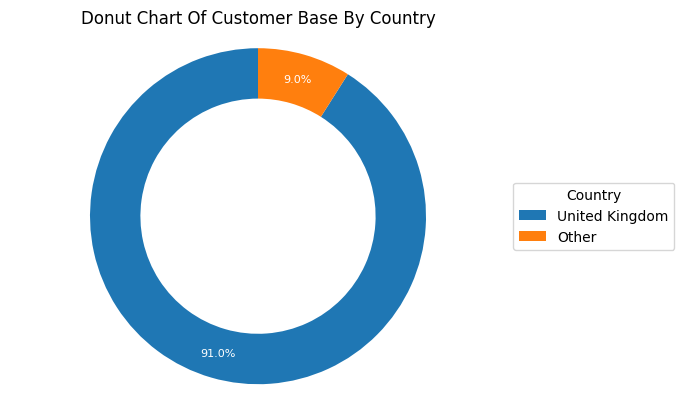

In [754]:
# Plot donut chart for countries distribution
plot_donut_chart(
    unique_country_counts,
    title="Donut Chart of Customer Base by Country",
    legend="country",
)

The U.K. sweeps all other countries with a majority percenteage of 91.0%. The second largest customer base is Other at 9.0% accounting for 40 different countries.

### Analyzing the Frequency of Transactions per month.


In [759]:
# Count the number of orders for each month
#unique_month_counts =  retail_data.groupby("month")["customer_id"].nunique().sort_values(ascending=False)
month_counts = retail_data["month"].value_counts()
print(month_counts)

month
November     159540
October      117957
December     111582
September     91234
March         77007
June          75812
July          72019
May           71076
August        67762
January       65798
April         63012
February      55962
Name: count, dtype: int64


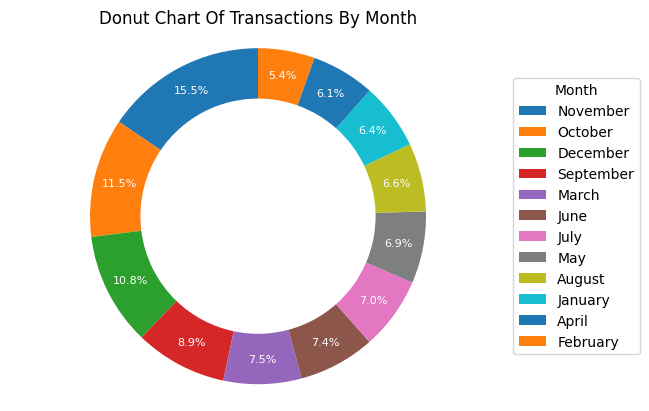

In [760]:
# Plot donut chart illustrating transaction distribution by month
plot_donut_chart(
    month_counts,
    title="Donut Chart of Transactions by Month",
    legend="month",
    threshold=41,
)

According to out dataset, the highest volume of transactions occurs in the months November, and December. I think this makes sense because the U.K.-based store we are analyzing sells gifts and the majority of gift giving holidays occur at the end of the year.

### Analyzing the Distribution of Topics

In [207]:
# Count number of orders for each topic
topic_counts = retail_data["topic"].value_counts()
print(topic_counts)

topic
Home Decor/Accessories                        179636
Artistic Home Decor/Accessories               133598
Home Decor/Artistic Floral Arrangements       131592
Assorted Party/Decorative Items               123345
Decorative/Themed Candle Set                  116994
Vintage Home Decor/Accessories                112589
Artistic/Decorative Craft Supplies            111270
Retro-inspired Kitchen or Home Decor Gifts     99868
Name: count, dtype: int64


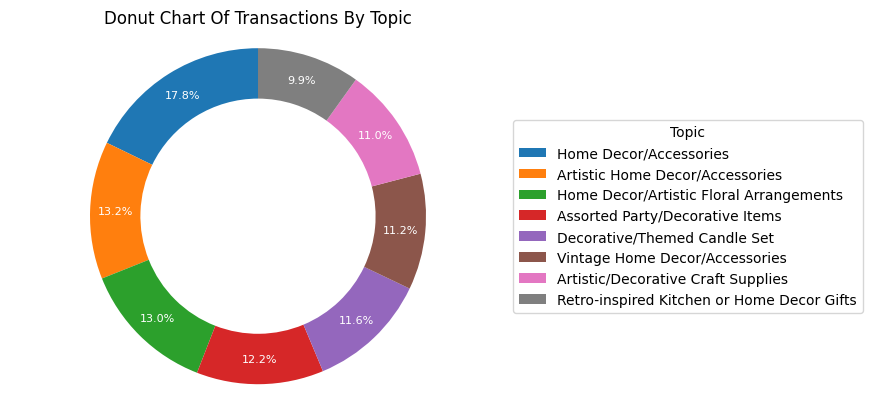

In [208]:
# Plot donut chart analyzing how often each topic category was purchased
plot_donut_chart(
    topic_counts, title="Donut Chart of Transactions by Topic", legend="topic"
)

This donut chart shows us that the most commonly purchasesd item categories from the U.K. store are 'Home Decor/Accessories', 'Decorative/Themed Candle Set', and 'Vintage Home Decor/Accessories'. These are all home related items and probably tangentially related in terms of our LDA topic model.

### Analyzing Diustribution of Quantities Purchased 

In [209]:
# Count number of orders for each quantity cateogry
quantity_counts = retail_data["quantity"].value_counts()
print(quantity_counts)

quantity
low_quantity       503355
medium_quantity    371088
high_quantity      134449
Name: count, dtype: int64


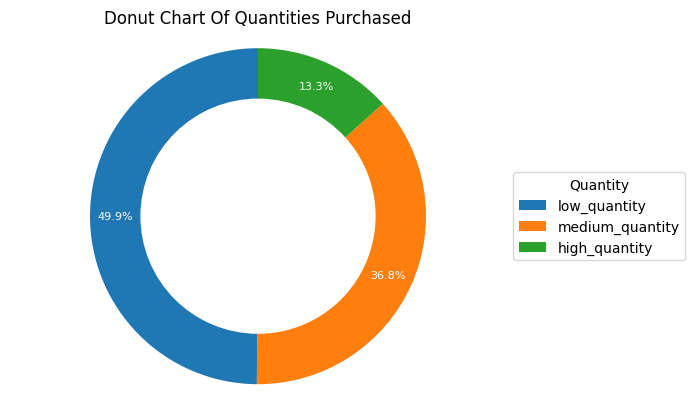

In [210]:
# Plot donut chart analyzing the distriubtion of quantity categories we defined
plot_donut_chart(
    quantity_counts,
    title="Donut Chart of Quantities Purchased",
    legend="quantity",
)

This donut chart shows us that customers most commonly buy low quantities, medium quantities, and high quantities of gifts, in that order. To break down the proportions more analytically:

- 49.9% of purchases were a low quantity (1-3) of items.
- 36.8% of purchases were a medium quantity (3-12) of items.
- 13.3% of purchases were a high quantity (12-80,996) of items.


### Analyzing Diustribution of Prices sold

In [211]:
# Count number of orders for each price cateogry
price_counts = retail_data["price"].value_counts()
print(price_counts)

price
very_low_price    304053
high_price        251066
low_price         227507
medium_price      226266
Name: count, dtype: int64


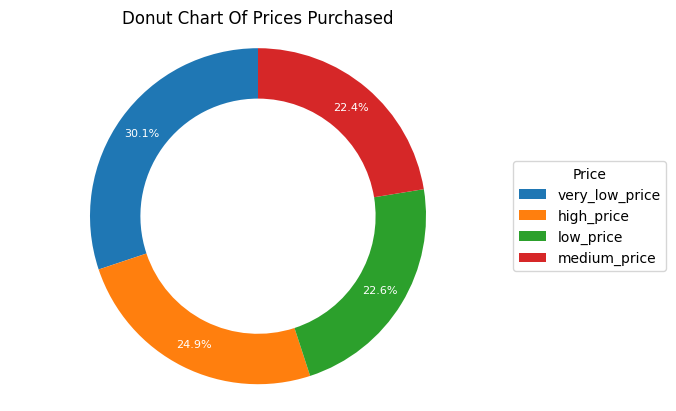

In [212]:
# Plot donut chart analyzing the distriubtion of price categories we defined
plot_donut_chart(
    price_counts,
    title="Donut Chart of Prices Purchased",
    legend="price",
)

Here, this donut chart illustrates that customers most commonly tend to buy very low price items, low price items, high price items, low price items, and medium price items, in that order. To break down these categories analytically:

- 30.1% of the purchases were very low priced (0£-1.25£) items.
- 24.9% of the purchases were high priced (4.13£-25111.90£) items.
- 22.6% of the purchases were low priced (1.25£-2.10£) items.
- 22.4% of the purchases were medium priced (2.10£-4.13£) items.

## Customer Segmentation using K-Modes Clustering
---

While the traditional K-Means clustring algorithm does a great job with continuous numeric data, it does not work well for variable data which is the format I would like to use. I think it will be easier to intuitively categorize customer clusters by combinations of categories (i.e. 'medium price, high quantity, U.K., and 'Home Decor/Accessores'). Fortunately, there is an approach well-tailored for this task called "K-Modes clustering".

K-Modes (proposed by Huang, Z in 1997) uses a measure of dissimilarity for categorical objects and iterates over clusters, choosing new modes each time with the aim of minimizing the measure of dissimilarity. Just like any other clustering approach, I need to decide when to stop with segmenting the data into clusters, choosing an optimal number of clusters. The best way to do this is by evaluating an Elbow Plot.

In [213]:
# Create a relevant subset of retail_data that you want to cluster on
cluster_input = retail_data[["quantity", "price", "country", "month", "topic"]]

In [214]:
cluster_input.head()

,quantity,price,country,month,topic
0,medium_quantity,high_price,United Kingdom,December,Decorative/Themed Candle Set
1,medium_quantity,high_price,United Kingdom,December,Retro-inspired Kitchen or Home Decor Gifts
2,medium_quantity,high_price,United Kingdom,December,Home Decor/Accessories
3,high_quantity,low_price,United Kingdom,December,Home Decor/Artistic Floral Arrangements
4,high_quantity,very_low_price,United Kingdom,December,Home Decor/Accessories


KModes started at 2023-10-19 11:51:05.332207
Initialization method and algorithm are deterministic. Setting n_init to 1.


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2973293.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 98411, cost: 2557809.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2494774.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2306008.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2197525.0
Initialization method and algorithm a

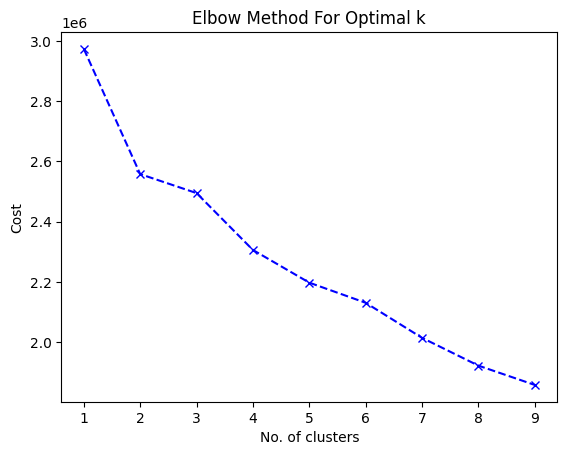

In [215]:
print(f"KModes started at {pd.Timestamp.now()}")

# Use an elbow curve to find the optimal k
cost = []
k = range(1, 10)
for num_clusters in list(k):
    kmode = KModes(n_clusters=num_clusters, n_init=5, verbose=1, random_state=42)
    kmode.fit_predict(cluster_input)
    cost.append(kmode.cost_)

print(f"Completed at {pd.Timestamp.now()}")

plt.plot(k, cost, "bx--")
plt.xlabel("No. of clusters")
plt.ylabel("Cost")
plt.title("Elbow Method For Optimal k")
plt.show()

The result of our Elbow Plot indicates that 4 clustrers is a good number to go with. The pace of the decline in the cost metric slows significantly after 4 clusters.  

With 4 clusters decided, we will re-run the K-Modes clustering specifying 4 clusters.

In [223]:
# Fit optimal K-Modes model with 4 clusters
kmode_opt = KModes(n_clusters=4, n_init=5, verbose=1, random_state=42)
cluster_assignmnets = kmode_opt.fit_predict(cluster_input)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2306008.0


In [224]:
# Add cluster assignments back to the original dataframe
retail_data["cluster"] = cluster_assignmnets

In [225]:
retail_data.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,revenue,month,topic,cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,83.4,December,Decorative/Themed Candle Set,1
1,489434,79323P,PINK CHERRY LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,December,Retro-inspired Kitchen or Home Decor Gifts,1
2,489434,79323W,WHITE CHERRY LIGHTS,medium_quantity,2009-12-01 07:45:00,high_price,13085.0,United Kingdom,81.0,December,Home Decor/Accessories,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",high_quantity,2009-12-01 07:45:00,low_price,13085.0,United Kingdom,100.8,December,Home Decor/Artistic Floral Arrangements,2
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,high_quantity,2009-12-01 07:45:00,very_low_price,13085.0,United Kingdom,30.0,December,Home Decor/Accessories,0


### Visualizing the Distribution of Our Clusters

In [226]:
# Count the number of orders for each cluster
cluster_counts = retail_data["cluster"].value_counts()
print(cluster_counts)

cluster
0    526103
1    236042
3    154137
2     92610
Name: count, dtype: int64


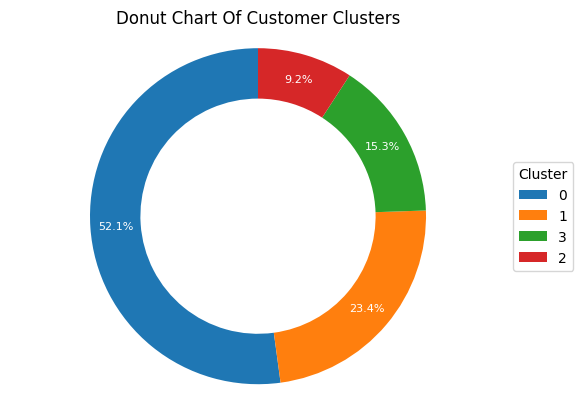

In [227]:
# Plot a donut chart visualizing the distribution of our 4 clusters
plot_donut_chart(
    cluster_counts,
    title="Donut Chart of Customer Clusters",
    legend="cluster",
)

In [228]:
kmode_opt.cluster_centroids_

array([['low_quantity', 'very_low_price', 'United Kingdom', 'November',
        'Home Decor/Accessories'],
       ['medium_quantity', 'high_price', 'United Kingdom', 'October',
        'Artistic Home Decor/Accessories'],
       ['high_quantity', 'low_price', 'United Kingdom', 'December',
        'Home Decor/Artistic Floral Arrangements'],
       ['low_quantity', 'high_price', 'United Kingdom', 'December',
        'Assorted Party/Decorative Items']], dtype='<U39')

Of our four clusters, cluster 0 makes up the most of our transactions, followed by cluster 1, cluster 3, and cluster 2. Here is a more comprehensive breakdown of cluster demographics:

- Cluster 1: These customers are from the United Kingdom and tend to make a "low quantity" (1-3 items) of purchases in November that are classified as "very low price" (0£-1.25£) in the "Home Decor/Accessories" category.

- Cluster 2: These customers are from the United Kingdom and tend to make a "medium quantity" (3-12 items) of purchases in October that are classified as "high price" (4.13£-25111.90£) in the "Artistic Home Decor/Accessories" category.

- Cluster 3: These customers are from the United Kingdom and tend to make a "high quantity" (12-80,996 items) of purchases in December classified as "low price" (1.25£-2.10£) in the "Home Decor/Artistic Floral Arrangements" category.

- Cluster 4: These customers are from the United Kingdom and tend to make a "low quantity" (1-3 items) of purchases in December classified as "high price" (4.13£-25111.90£) in the "Assorted Party/Decorative Items" category.  

General impressions: One of the first things I notice here is that all of our defined clusters only include United Kingdom customers. As we know from earlier the overwhelming majority of the customer base in our dataset is from the U.K. and any outside customer base is so nominal that our clusters do not count them as significant. This will make our time series forecasting later on more straightforward since we won't include the noise of international customers.



## Using ARIMA/SARIMA  for Time Series Forecasting
---

For this problem, we use forecasting in an attempt to provide this U.K. company with business insights so it can plan procurement and production activities. We will use ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) to tackle this problem, making the fundamental assumption that the information in the past values of our time series can alone be used to predict the future values of revenue.  

<u>ARIMA model</u>

ARIMA is a popular time series forecasting model that combines autoregressive (AR) and moving average (MA) components with differencing to handle non-stationary data. There are three components:  

1. **Autoregressive (AR)**: It models the linear relationship between the current observation and a number *p* of lagged observations. It captures the dependency of the current value on its past values.
1. **Moving Average (MA)**: It models the dependency of the current observation on a number *q* of residual errors from previous observations. It captures the short-term shocks or random fluctuations in the data.
1. **Integration (I)**: It accounts for the differencing required to make the time series stationary. Differencing involves subtracting the previous observation from the current observation to remove trends or seasonality. The order of differencing, denoted by *d*, represents the number of times differencing is applied to achieve stationarity.  

By combining these three components (AR, I, MA), the ARIMA model is capable of capturing the linear dependencies and trends in time series data. The order of the ARIMA model is typically represented as (*p*, *d*, *q*) where *p* represents the order of the AR component, *d* represents the order of differencing, and *q* represents the order of the MA component.   

<u>SARIMA model</u>  

Since our data most likely has seasonal components, we will use SARIMA which incorporates seasonal components to handle time series data with recurring patterns at fixed intervals, such as daily, weekly, or yearly cycles. SARIMA includes additional seasoal AR, MA, and I components in addition to the ones included in ATIMA. The order of the SARIMA model is typically denoted as (*p*, *d*, *q*)(*P*, *D*, *Q*, *m*) where lowercase parameters refer to non-seasonal components and uppercase represent seasonal componenets.


To get a general trend of seasonality's impact on revenue, we will look at a plot of average revenue vs. month.

C:\Users\evans\AppData\Local\Temp\ipykernel_30108\2440084345.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_monthly_rev = retail_data.sort_values('month').groupby('month')['revenue'].mean()


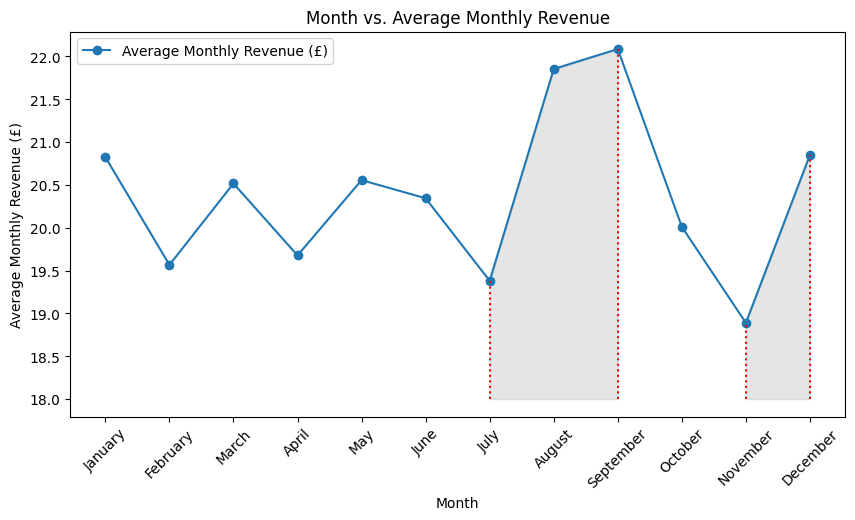

In [262]:
# Convert 'month' to a categorical type with abbreviations with a custom ordering
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
retail_data["month"] = pd.Categorical(
    retail_data["month"], categories=month_order, ordered=True
)

# Sort the DataFrame based on the custom ordering of 'month'
avg_monthly_rev = retail_data.sort_values("month").groupby("month")["revenue"].mean()

# Set the figure size to make it longer
plt.figure(figsize=(10, 5))

# Plot average revenue line
plt.plot(
    avg_monthly_rev.index,
    avg_monthly_rev.values,
    marker="o",
    label="Average Monthly Revenue (£)",
)

# Months to highlight
highlight_months = ["July", "September", "November", "December"]

# Draw vertical lines for selected months
for month in highlight_months:
    month_index = month_order.index(month)
    x_value = avg_monthly_rev.index[month_index]
    y_value = avg_monthly_rev.values[month_index]
    plt.vlines(x=x_value, ymin=18, ymax=y_value, linestyles="dotted", colors="red")

# Shade the regions between vertical lines
for i in range(1, len(highlight_months), 2):
    start_month = highlight_months[i - 1]
    end_month = highlight_months[i]
    start_index = month_order.index(start_month)
    end_index = month_order.index(end_month)
    plt.fill_between(
        avg_monthly_rev.index[start_index : end_index + 1],
        18,
        avg_monthly_rev.values[start_index : end_index + 1],
        alpha=0.2,
        color="gray",
    )

plt.xlabel("Month")
plt.ylabel("Average Monthly Revenue (£)")
plt.title("Month vs. Average Monthly Revenue")
plt.xticks(rotation=45)  # Rotate x-axis tick labels for better visibility
plt.legend()
plt.show()

The plot of Month Vs. Average Monthly Revenue, indicates that there could indeed be seasonal impact for revenue of our store. Betwen the months of July and Septmber, there is a clear increase in average monthly revenue followed by a steady decrease from September to November. From November to December, the average monthly revenue begins to swiftly increase again.  